In [ ]:
from IPython.display import clear_output
!pip install imutils
! pip install -U segmentation-models
!pip install -q tensorflow==2.2.1
!pip install -q keras==2.5 #segementation_models supports this version of keras
clear_output()

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
!nvidia-smi

Sat May  6 07:41:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |    373MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import cv2
import numpy as np
import shutil
from matplotlib import pyplot as plt
import tensorflow as tf

#importing segmentation_models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

from tensorflow.keras.metrics import MeanIoU
import random

Segmentation Models: using `tf.keras` framework.


In [ ]:
! mkdir 'data/' 'data/Train' 'data/Val' 'data/Train/images'  'data/Train/masks' 'data/Val/images'  'data/Val/masks'

In [ ]:
#CHecking the directories are formed or not correctly
!apt-get install tree
clear_output()
!tree -d

.
├── data
│   ├── Train
│   │   ├── images
│   │   └── masks
│   └── Val
│       ├── images
│       └── masks
└── sample_data

8 directories


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [ ]:
#For personalID
# Train_img_path = '/gdrive/MyDrive/ML/Patch Images/Train/images/'
# Train_msk_path = '/gdrive/MyDrive/ML/Patch Images/Train/masks/'
# Val_img_path = '/gdrive/MyDrive/ML/Patch Images/Val/images/'
# Val_msk_path = '/gdrive/MyDrive/ML/Patch Images/Val/masks/'

In [ ]:
# For clg id
Train_img_path = '/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Patch Images/Train/images/'
Train_msk_path = '/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Patch Images/Train/masks/'
Val_img_path = '/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Patch Images/Val/images/'
Val_msk_path = '/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Patch Images/Val/masks/'

In [ ]:
temp = cv2.imread(Train_msk_path + os.listdir(Train_msk_path)[0])

Labels are:  [  0   1   2   3   4   5   6   7   8   9 247 248 249 250 251 252 253 254
 255]  and the counts are:  [62566   110   102    63    33    18     9     3     2     1     4     3
    11    19    31    47    74    86  2354]


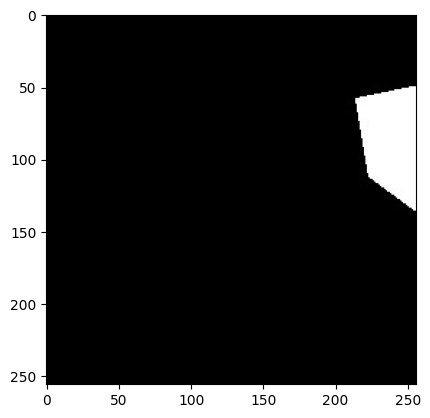

In [ ]:
#Checking number of labels in the mask
labels, count = np.unique(temp[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)
plt.imshow(temp)

Labels are:  [  0 255]  and the counts are:  [188721   7887]


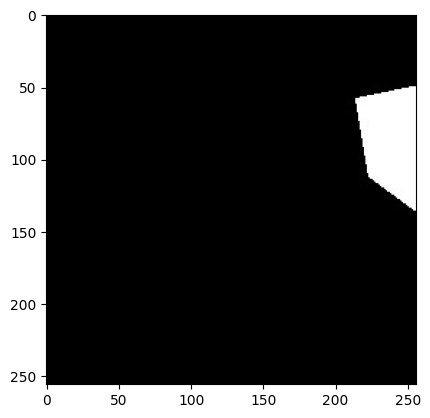

In [ ]:
#Converting multi-lablels to binary labels.
temp2 = 255 * (temp > 128)
labels, count = np.unique(temp2, return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)
plt.imshow(temp)

In [ ]:
cv2.imwrite( "/content/data" + '/1.JPG', temp)

True

In [ ]:
def Training_Dir_Prep(srs_imgs, srs_msks, tar_imgs, tar_msks):
  i = 0
  for img in os.listdir(srs_imgs):
    image = srs_imgs + img

    mask = cv2.imread(srs_msks + img)
    mask = (mask > 128) * 255
    labels, count = np.unique(mask, return_counts=True)
    # print("Labels are: ", labels, " and the counts are: ", count)

    shutil.copy(image, tar_imgs + str(i) + '.JPG')
    cv2.imwrite(tar_msks + str(i) + '.JPG', mask)
    i = i+1

In [ ]:
Training_Dir_Prep(Train_img_path, Train_msk_path, '/content/data/Train/images/', '/content/data/Train/masks/')
Training_Dir_Prep(Val_img_path, Val_msk_path, '/content/data/Val/images/', '/content/data/Val/masks/')

Labels are:  [  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]  and the counts are:  [39930   328   189   106    33    17     5     1     5     1    12    28
    96   199   323 24263]


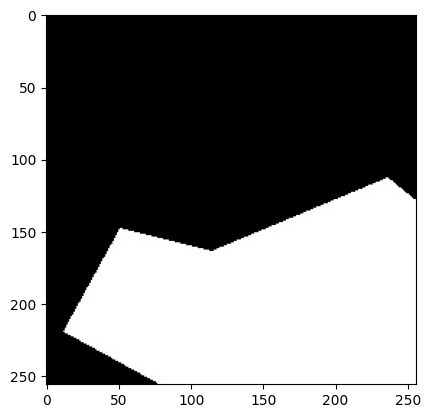

In [ ]:
temp_mask = cv2.imread("/content/data/Val/masks/10.JPG") #3 channels but all same.
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)
plt.imshow(temp_mask)
# temp_mask = (temp_mask > 128) * 255
# labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
# print("Labels are: ", labels, " and the counts are: ", count)

In [ ]:
print(os.listdir('/content/data/Train/images'))
print(os.listdir('/content/data/Train/masks'))

['547.JPG', '540.JPG', '40.JPG', '133.JPG', '173.JPG', '408.JPG', '640.JPG', '460.JPG', '722.JPG', '791.JPG', '181.JPG', '782.JPG', '615.JPG', '204.JPG', '826.JPG', '796.JPG', '779.JPG', '169.JPG', '145.JPG', '597.JPG', '393.JPG', '492.JPG', '865.JPG', '565.JPG', '101.JPG', '509.JPG', '119.JPG', '389.JPG', '505.JPG', '723.JPG', '282.JPG', '433.JPG', '624.JPG', '217.JPG', '135.JPG', '770.JPG', '601.JPG', '91.JPG', '768.JPG', '139.JPG', '860.JPG', '754.JPG', '132.JPG', '750.JPG', '152.JPG', '766.JPG', '538.JPG', '210.JPG', '183.JPG', '167.JPG', '702.JPG', '159.JPG', '639.JPG', '74.JPG', '788.JPG', '494.JPG', '423.JPG', '318.JPG', '129.JPG', '163.JPG', '697.JPG', '636.JPG', '284.JPG', '107.JPG', '627.JPG', '134.JPG', '831.JPG', '546.JPG', '544.JPG', '10.JPG', '792.JPG', '653.JPG', '535.JPG', '298.JPG', '320.JPG', '758.JPG', '259.JPG', '420.JPG', '738.JPG', '359.JPG', '269.JPG', '684.JPG', '36.JPG', '121.JPG', '719.JPG', '339.JPG', '13.JPG', '397.JPG', '153.JPG', '852.JPG', '747.JPG', '478

In [ ]:
train_img_dir = "/content/data/Train/images/"
train_mask_dir = "/content/data/Train/masks/"

In [ ]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [ ]:
print(img_list[:5])
print(msk_list[:5])

['547.JPG', '540.JPG', '40.JPG', '133.JPG', '173.JPG']
['547.JPG', '540.JPG', '40.JPG', '133.JPG', '173.JPG']


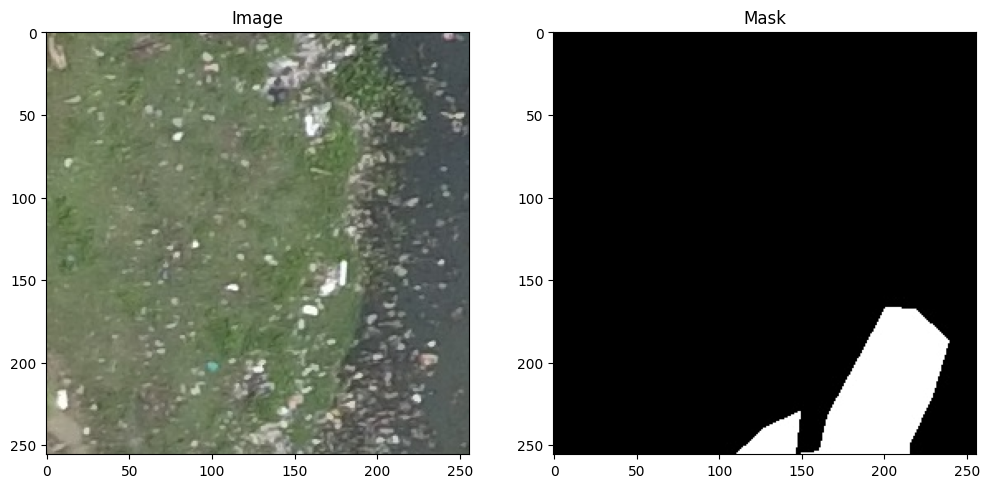

In [ ]:
#Get an understanding by looking at a few random images and masks
num_images = len(img_list)

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir + img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+img_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
Val_img_dir = "/content/data/Val/images/"
Val_mask_dir = "/content/data/Val/masks/"

In [ ]:
def data_loader(Path_dir):
    image_dataset = []
    for images in os.listdir(Path_dir):
        image = cv2.imread(Path_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return np.array(image_dataset)

In [ ]:
X_TRAIN = data_loader("/content/data/Train/images")
y_TRAIN = data_loader("/content/data/Train/masks")
X_VAL = data_loader("/content/data/Val/images")
y_VAL = data_loader("/content/data/Val/masks")

In [ ]:
y_TRAIN = (y_TRAIN > 128) * 255
y_VAL = (y_VAL > 128) * 255

In [ ]:
labels, count = np.unique(y_VAL, return_counts=True)
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [  0 255]  and the counts are:  [16645659  2621925]


In [ ]:
X_TRAIN = X_TRAIN/ 255.0
y_TRAIN = y_TRAIN/ 255.0
X_VAL = X_VAL / 255.0
y_VAL = y_VAL / 255.0

In [ ]:
labels, count = np.unique(y_TRAIN, return_counts=True)
print("Labels are: ", labels, " and the counts are: ", count)

Labels are:  [0. 1.]  and the counts are:  [150698040  22906824]


In [ ]:
X_TRAIN.shape

(883, 256, 256, 3)

In [ ]:
# define model
# model = sm.Unet(BACKBONE, encoder_weights='imagenet',
#                 input_shape=(256,256,3),
#                 classes=n_classes, activation='relu')

#UNET architecture

inputs = tf.keras.layers.Input((256,256,3))
s = tf.keras.layers.Lambda(lambda x: x )(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='relu')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])


model.compile('Adam', loss=sm.losses.binary_crossentropy, metrics=[sm.metrics.iou_score])

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(X_TRAIN, y_TRAIN,
                    batch_size = 16,
                    verbose = 1,
                    epochs = 50,
                    validation_data = (X_VAL, y_VAL),
                    shuffle = False,
                    callbacks = callbacks_list
                    )

Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 1.0507 - iou_score: 0.0623

56/56 [==============================] - 37s 261ms/step - loss: 1.0507 - iou_score: 0.0623 - val_loss: 0.9604 - val_iou_score: 0.0383
Epoch 2/50
55/56 [============================>.] - ETA: 0s - loss: 0.4415 - iou_score: 0.0772

56/56 [==============================] - 10s 186ms/step - loss: 0.4407 - iou_score: 0.0765 - val_loss: 0.3920 - val_iou_score: 0.0591
Epoch 3/50
55/56 [============================>.] - ETA: 0s - loss: 0.3270 - iou_score: 0.1295

56/56 [==============================] - 11s 188ms/step - loss: 0.3264 - iou_score: 0.1285 - val_loss: 0.4240 - val_iou_score: 0.0595
Epoch 4/50
55/56 [============================>.] - ETA: 0s - loss: 0.2742 - iou_score: 0.2098

56/56 [==============================] - 10s 187ms/step - loss: 0.2737 - iou_score: 0.2088 - val_loss: 0.3181 - val_iou_score: 0.1536
Epoch 5/50
55/56 [============================>.] - ETA: 0s - loss: 0.2460 - iou_score: 0.2554

56/56 [==============================] - 10s 185ms/step - loss: 0.2455 - iou_score: 0.2540 - val_loss: 0.3069 - val_iou_score: 0.1697
Epoch 6/50
55/56 [============================>.] - ETA: 0s - loss: 0.3050 - iou_score: 0.1731

56/56 [==============================] - 10s 183ms/step - loss: 0.3045 - iou_score: 0.1715 - val_loss: 0.3554 - val_iou_score: 0.0897
Epoch 7/50
55/56 [============================>.] - ETA: 0s - loss: 0.2574 - iou_score: 0.2311

56/56 [==============================] - 10s 184ms/step - loss: 0.2568 - iou_score: 0.2300 - val_loss: 0.2902 - val_iou_score: 0.1784
Epoch 8/50
55/56 [============================>.] - ETA: 0s - loss: 0.2371 - iou_score: 0.2770

56/56 [==============================] - 10s 184ms/step - loss: 0.2366 - iou_score: 0.2751 - val_loss: 0.2787 - val_iou_score: 0.1857
Epoch 9/50
55/56 [============================>.] - ETA: 0s - loss: 0.2531 - iou_score: 0.2461

56/56 [==============================] - 10s 184ms/step - loss: 0.2526 - iou_score: 0.2443 - val_loss: 0.3262 - val_iou_score: 0.1325
Epoch 10/50
55/56 [============================>.] - ETA: 0s - loss: 0.2336 - iou_score: 0.2737

56/56 [==============================] - 10s 187ms/step - loss: 0.2332 - iou_score: 0.2716 - val_loss: 0.2791 - val_iou_score: 0.1784
Epoch 11/50
55/56 [============================>.] - ETA: 0s - loss: 0.2203 - iou_score: 0.3104

56/56 [==============================] - 10s 184ms/step - loss: 0.2200 - iou_score: 0.3070 - val_loss: 0.3235 - val_iou_score: 0.1438
Epoch 12/50
55/56 [============================>.] - ETA: 0s - loss: 0.2213 - iou_score: 0.2971

56/56 [==============================] - 10s 184ms/step - loss: 0.2209 - iou_score: 0.2955 - val_loss: 0.2764 - val_iou_score: 0.2012
Epoch 13/50
55/56 [============================>.] - ETA: 0s - loss: 0.2139 - iou_score: 0.3241

56/56 [==============================] - 10s 183ms/step - loss: 0.2135 - iou_score: 0.3217 - val_loss: 0.2735 - val_iou_score: 0.1973
Epoch 14/50
55/56 [============================>.] - ETA: 0s - loss: 0.2293 - iou_score: 0.2796

56/56 [==============================] - 10s 184ms/step - loss: 0.2290 - iou_score: 0.2763 - val_loss: 0.3802 - val_iou_score: 0.0958
Epoch 15/50
55/56 [============================>.] - ETA: 0s - loss: 0.2371 - iou_score: 0.2655

56/56 [==============================] - 10s 184ms/step - loss: 0.2366 - iou_score: 0.2644 - val_loss: 0.2961 - val_iou_score: 0.1921
Epoch 16/50
55/56 [============================>.] - ETA: 0s - loss: 0.2237 - iou_score: 0.2914

56/56 [==============================] - 10s 183ms/step - loss: 0.2233 - iou_score: 0.2894 - val_loss: 0.2904 - val_iou_score: 0.1730
Epoch 17/50
56/56 [==============================] - ETA: 0s - loss: 0.2144 - iou_score: 0.3132

56/56 [==============================] - 10s 185ms/step - loss: 0.2144 - iou_score: 0.3132 - val_loss: 0.2868 - val_iou_score: 0.1867
Epoch 18/50
55/56 [============================>.] - ETA: 0s - loss: 0.2083 - iou_score: 0.3306

56/56 [==============================] - 10s 182ms/step - loss: 0.2080 - iou_score: 0.3281 - val_loss: 0.3053 - val_iou_score: 0.1949
Epoch 19/50
55/56 [============================>.] - ETA: 0s - loss: 0.2021 - iou_score: 0.3440

56/56 [==============================] - 10s 182ms/step - loss: 0.2017 - iou_score: 0.3423 - val_loss: 0.2959 - val_iou_score: 0.2416
Epoch 20/50
55/56 [============================>.] - ETA: 0s - loss: 0.2045 - iou_score: 0.3435

56/56 [==============================] - 10s 185ms/step - loss: 0.2042 - iou_score: 0.3413 - val_loss: 0.3414 - val_iou_score: 0.1844
Epoch 21/50
55/56 [============================>.] - ETA: 0s - loss: 0.2006 - iou_score: 0.3530

56/56 [==============================] - 10s 184ms/step - loss: 0.2002 - iou_score: 0.3509 - val_loss: 0.3126 - val_iou_score: 0.2161
Epoch 22/50
55/56 [============================>.] - ETA: 0s - loss: 0.1966 - iou_score: 0.3596

56/56 [==============================] - 10s 183ms/step - loss: 0.1962 - iou_score: 0.3580 - val_loss: 0.2921 - val_iou_score: 0.2462
Epoch 23/50
55/56 [============================>.] - ETA: 0s - loss: 0.1938 - iou_score: 0.3680

56/56 [==============================] - 10s 183ms/step - loss: 0.1934 - iou_score: 0.3662 - val_loss: 0.2952 - val_iou_score: 0.2355
Epoch 24/50
55/56 [============================>.] - ETA: 0s - loss: 0.2019 - iou_score: 0.3400

56/56 [==============================] - 10s 183ms/step - loss: 0.2015 - iou_score: 0.3391 - val_loss: 0.3433 - val_iou_score: 0.2259
Epoch 25/50
55/56 [============================>.] - ETA: 0s - loss: 0.1980 - iou_score: 0.3628

56/56 [==============================] - 10s 183ms/step - loss: 0.1976 - iou_score: 0.3611 - val_loss: 0.2400 - val_iou_score: 0.2785
Epoch 26/50
56/56 [==============================] - ETA: 0s - loss: 0.1912 - iou_score: 0.3703

56/56 [==============================] - 10s 184ms/step - loss: 0.1912 - iou_score: 0.3703 - val_loss: 0.2633 - val_iou_score: 0.2551
Epoch 27/50
55/56 [============================>.] - ETA: 0s - loss: 0.2119 - iou_score: 0.3204

56/56 [==============================] - 10s 183ms/step - loss: 0.2115 - iou_score: 0.3181 - val_loss: 0.3217 - val_iou_score: 0.1727
Epoch 28/50
55/56 [============================>.] - ETA: 0s - loss: 0.2002 - iou_score: 0.3435

56/56 [==============================] - 10s 184ms/step - loss: 0.1998 - iou_score: 0.3422 - val_loss: 0.2966 - val_iou_score: 0.2404
Epoch 29/50
55/56 [============================>.] - ETA: 0s - loss: 0.1929 - iou_score: 0.3618

56/56 [==============================] - 10s 184ms/step - loss: 0.1924 - iou_score: 0.3609 - val_loss: 0.3272 - val_iou_score: 0.2109
Epoch 30/50
55/56 [============================>.] - ETA: 0s - loss: 0.1929 - iou_score: 0.3605

56/56 [==============================] - 10s 184ms/step - loss: 0.1925 - iou_score: 0.3600 - val_loss: 0.2977 - val_iou_score: 0.2410
Epoch 31/50
55/56 [============================>.] - ETA: 0s - loss: 0.1839 - iou_score: 0.3906

56/56 [==============================] - 10s 183ms/step - loss: 0.1835 - iou_score: 0.3894 - val_loss: 0.2374 - val_iou_score: 0.3070
Epoch 32/50
55/56 [============================>.] - ETA: 0s - loss: 0.1810 - iou_score: 0.3931

56/56 [==============================] - 10s 184ms/step - loss: 0.1807 - iou_score: 0.3918 - val_loss: 0.2428 - val_iou_score: 0.2973
Epoch 33/50
55/56 [============================>.] - ETA: 0s - loss: 0.1799 - iou_score: 0.4015

56/56 [==============================] - 10s 184ms/step - loss: 0.1795 - iou_score: 0.4002 - val_loss: 0.2654 - val_iou_score: 0.2874
Epoch 34/50
55/56 [============================>.] - ETA: 0s - loss: 0.1836 - iou_score: 0.3842

56/56 [==============================] - 10s 184ms/step - loss: 0.1832 - iou_score: 0.3837 - val_loss: 0.3140 - val_iou_score: 0.2381
Epoch 35/50
55/56 [============================>.] - ETA: 0s - loss: 0.1823 - iou_score: 0.3928

56/56 [==============================] - 10s 182ms/step - loss: 0.1819 - iou_score: 0.3921 - val_loss: 0.2735 - val_iou_score: 0.2699
Epoch 36/50
55/56 [============================>.] - ETA: 0s - loss: 0.1794 - iou_score: 0.3957

56/56 [==============================] - 10s 183ms/step - loss: 0.1790 - iou_score: 0.3950 - val_loss: 0.2731 - val_iou_score: 0.2727
Epoch 37/50
55/56 [============================>.] - ETA: 0s - loss: 0.1847 - iou_score: 0.3780

56/56 [==============================] - 10s 185ms/step - loss: 0.1843 - iou_score: 0.3774 - val_loss: 0.2777 - val_iou_score: 0.2722
Epoch 38/50
55/56 [============================>.] - ETA: 0s - loss: 0.1796 - iou_score: 0.4029

56/56 [==============================] - 10s 184ms/step - loss: 0.1792 - iou_score: 0.4024 - val_loss: 0.2841 - val_iou_score: 0.2669
Epoch 39/50
55/56 [============================>.] - ETA: 0s - loss: 0.1880 - iou_score: 0.3767

56/56 [==============================] - 10s 183ms/step - loss: 0.1876 - iou_score: 0.3749 - val_loss: 0.3414 - val_iou_score: 0.1763
Epoch 40/50
55/56 [============================>.] - ETA: 0s - loss: 0.1836 - iou_score: 0.3897

56/56 [==============================] - 10s 181ms/step - loss: 0.1832 - iou_score: 0.3901 - val_loss: 0.2746 - val_iou_score: 0.2887
Epoch 41/50
55/56 [============================>.] - ETA: 0s - loss: 0.1847 - iou_score: 0.3761

56/56 [==============================] - 10s 183ms/step - loss: 0.1842 - iou_score: 0.3762 - val_loss: 0.2470 - val_iou_score: 0.3059
Epoch 42/50
55/56 [============================>.] - ETA: 0s - loss: 0.1758 - iou_score: 0.4065

56/56 [==============================] - 10s 184ms/step - loss: 0.1754 - iou_score: 0.4058 - val_loss: 0.2336 - val_iou_score: 0.3068
Epoch 43/50
56/56 [==============================] - ETA: 0s - loss: 0.1710 - iou_score: 0.4176

56/56 [==============================] - 10s 184ms/step - loss: 0.1710 - iou_score: 0.4176 - val_loss: 0.2706 - val_iou_score: 0.2797
Epoch 44/50
55/56 [============================>.] - ETA: 0s - loss: 0.1742 - iou_score: 0.4142

56/56 [==============================] - 10s 183ms/step - loss: 0.1738 - iou_score: 0.4128 - val_loss: 0.2380 - val_iou_score: 0.2604
Epoch 45/50
55/56 [============================>.] - ETA: 0s - loss: 0.1768 - iou_score: 0.4014

56/56 [==============================] - 10s 182ms/step - loss: 0.1764 - iou_score: 0.4023 - val_loss: 0.2446 - val_iou_score: 0.3295
Epoch 46/50
55/56 [============================>.] - ETA: 0s - loss: 0.1714 - iou_score: 0.4198

56/56 [==============================] - 10s 182ms/step - loss: 0.1710 - iou_score: 0.4199 - val_loss: 0.2947 - val_iou_score: 0.2756
Epoch 47/50
55/56 [============================>.] - ETA: 0s - loss: 0.1704 - iou_score: 0.4243

56/56 [==============================] - 10s 183ms/step - loss: 0.1700 - iou_score: 0.4247 - val_loss: 0.2725 - val_iou_score: 0.2858
Epoch 48/50
55/56 [============================>.] - ETA: 0s - loss: 0.1838 - iou_score: 0.3930

56/56 [==============================] - 10s 182ms/step - loss: 0.1834 - iou_score: 0.3902 - val_loss: 0.3021 - val_iou_score: 0.1904
Epoch 49/50
55/56 [============================>.] - ETA: 0s - loss: 0.1914 - iou_score: 0.3621

56/56 [==============================] - 10s 184ms/step - loss: 0.1909 - iou_score: 0.3616 - val_loss: 0.2180 - val_iou_score: 0.3282
Epoch 50/50
55/56 [============================>.] - ETA: 0s - loss: 0.1724 - iou_score: 0.4164

56/56 [==============================] - 10s 183ms/step - loss: 0.1720 - iou_score: 0.4167 - val_loss: 0.2752 - val_iou_score: 0.3078


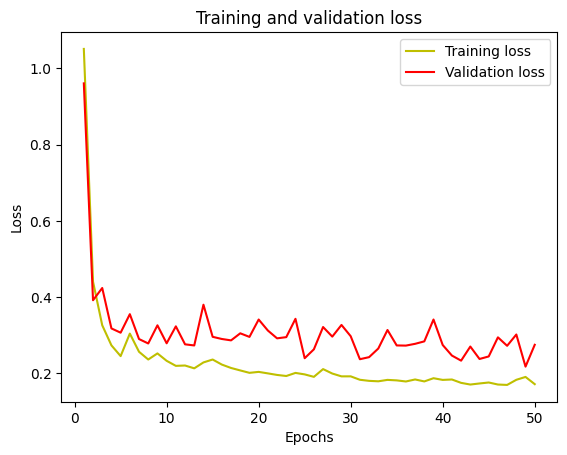

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

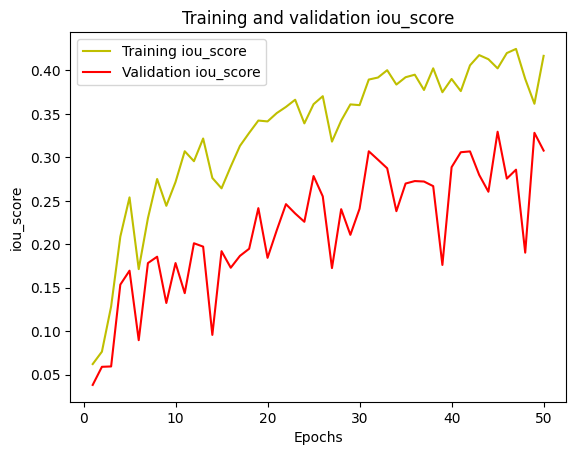

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training iou_score')
plt.plot(epochs, val_acc, 'r', label='Validation iou_score')
plt.title('Training and validation iou_score')
plt.xlabel('Epochs')
plt.ylabel('iou_score')
plt.legend()
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Garbage Detection/Model_V1.h5")

4/4 [==============================] - 3s 45ms/step


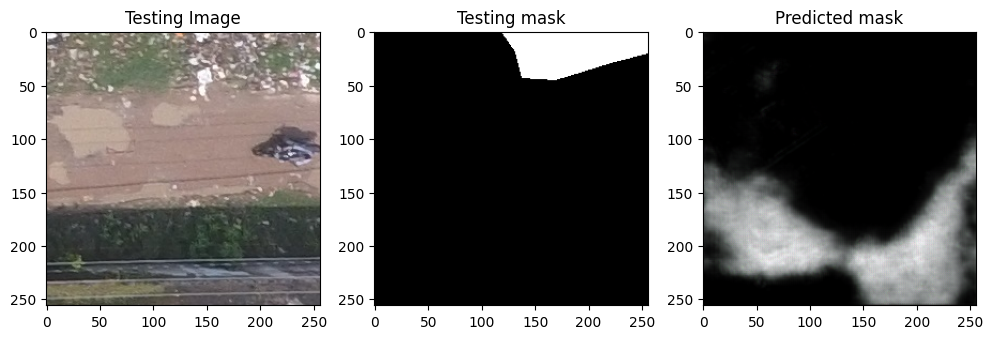

In [ ]:
Test_Pred = model.predict(X_VAL)
plt.figure(figsize = (12,8))
plt.subplot(2,3,1)
plt.title('Testing Image')
plt.imshow(X_VAL[0])
plt.subplot(2,3,2)
plt.title('Testing mask')
plt.imshow(y_VAL[])
plt.subplot(2,3,3)
plt.title('Predicted mask')
plt.imshow(Test_Pred[3])

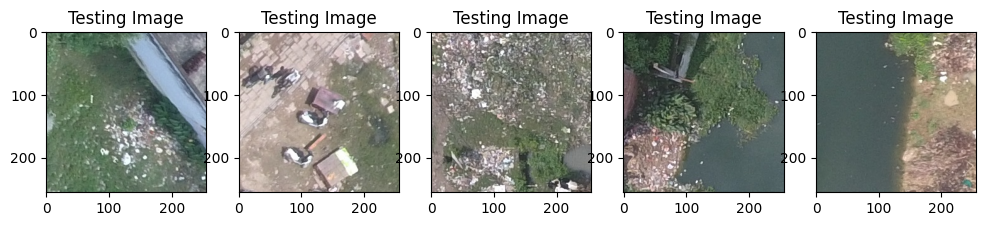

In [ ]:
plt.figure(figsize = (12,8))
for x in range(5):
  plt.subplot(1,5,x+1)
  plt.title('Testing Image')
  plt.imshow(X_VAL[x+10])

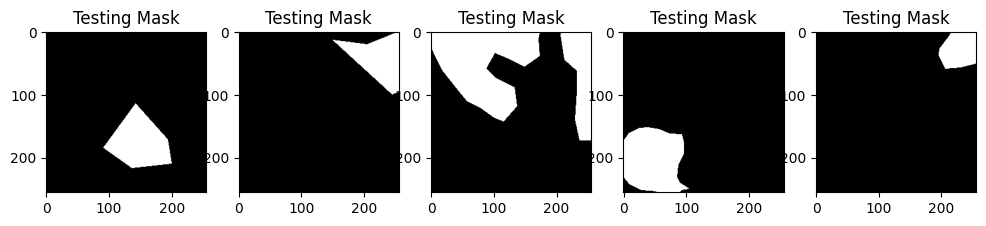

In [ ]:
plt.figure(figsize = (12,8))
for x in range(5):
  plt.subplot(1,5,x+1)
  plt.title('Testing Mask')
  plt.imshow(y_VAL[x+10] )

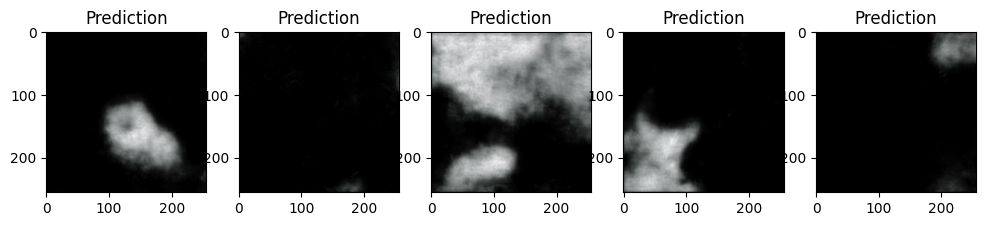

In [ ]:
plt.figure(figsize = (12,8))
for x in range(5):
  plt.subplot(1,5,x+1)
  plt.title('Prediction')
  plt.imshow(Test_Pred[x+10] )